In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import  make_scorer, balanced_accuracy_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, recall_score, precision_score, matthews_corrcoef
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [3]:
import shap

In [4]:
def upload_data(graph2vec_file, rna_file):

    embeddings = pd.read_csv(graph2vec_file, index_col=0)
    metadata = pd.read_csv(rna_file, index_col=0)
    metadata['PFS_label'] = pd.cut(metadata['PFS'], bins=[0, 3.5, np.inf], labels=['NR', 'R'])
    results = pd.concat([embeddings, metadata[['PFS_label']]], axis=1)
    return results

In [5]:
def get_params(name):
    if name == 'RandomForestClassifier':
        method = RandomForestClassifier(random_state=0)
        grid = {'min_samples_leaf': [1, 2],
            'min_samples_split': [2, 3, 4, 5, 6, 8, 9, 10],
            'n_estimators': [5, 10, 15, 20, 25, 30],
            'bootstrap': [True, False],
            'criterion': ['gini', 'entropy'],
            'max_depth':[None, 1, 2, 3, 5, 7, 10,50]
            }
    return method, grid

In [35]:
def cv_score(name, x_train_sc, x_test_sc, y_train, y_test,  e, wl, dim, scoring_list = None):

    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

    test_metrics = []; val_metrics = []; val_metrics_std = []; train_metrics  = []; train_metrics_std = []
    print(name)

    clf_method, clf_grid_params = get_params(name)

    # print('Fitting model...')
    clf = GridSearchCV(clf_method, clf_grid_params, cv=skf, scoring=scoring_list, refit='roc_auc', verbose=1, return_train_score=True)
    clf.fit(x_train_sc, y_train)
    val_results = clf.cv_results_
    # print(val_results)
    best_index = clf.best_index_

    for s in scoring_list.keys():
        train_metrics.append(val_results['mean_train_'+str(s)][best_index])
        train_metrics_std.append(val_results['std_train_'+str(s)][best_index])
        val_metrics.append(val_results['mean_test_'+str(s)][best_index])
        val_metrics_std.append(val_results['std_test_'+str(s)][best_index])
    # print('Model trained:')
    best_model = clf.best_estimator_
    print(best_model)
    print("Best result of the cross validation of the model with the best paramters:" +str(clf.best_score_))
    print('TRAIN')
    print(train_metrics)
    print('VAL')
    print(val_metrics)
    print('VAL STD')
    print(val_metrics_std)
    #################### TEST ####################

    y_prob = best_model.predict_proba(x_test_sc)
    y_pred = best_model.predict(x_test_sc)
    test_metrics.append(balanced_accuracy_score(y_test, y_pred))
    test_metrics.append(f1_score(y_test, y_pred, average='weighted'))
    roc_auc = roc_auc_score(y_test, y_prob[:, 1])
    test_metrics.append(roc_auc)
    test_metrics.append(precision_score(y_test, y_pred, average='weighted'))
    test_metrics.append(recall_score(y_test, y_pred, average='weighted'))
    test_metrics.append(matthews_corrcoef(y_test, y_pred))
    print('TEST')
    print(test_metrics)
    # exit()
    # Save test confussion matrix
    confussion_matrix(y_test, y_pred, e, wl, dim, name)

    # Show auc_curve
    result_visualization(roc_auc, y_test, y_prob, name, e, wl, dim)

    # Save current model scores
    test_tmp = pd.DataFrame({f'{e}e_{wl}WL_{dim}dim': test_metrics}, index = score_list)
    train_tmp = pd.DataFrame({f'{e}e_{wl}WL_{dim}dim': train_metrics}, index = score_list)
    train_tmp_std = pd.DataFrame({f'{e}e_{wl}WL_{dim}dim': train_metrics_std}, index = score_list)
    val_tmp = pd.DataFrame({f'{e}e_{wl}WL_{dim}dim': val_metrics}, index = score_list)
    val_tmp_std = pd.DataFrame({f'{e}e_{wl}WL_{dim}dim': val_metrics_std}, index = score_list)

    return test_tmp, train_tmp, train_tmp_std, val_tmp, val_tmp_std, best_model

In [36]:
def plot_train_test_metrics(train_scores, test_scores, name):

    for index, row in train_scores.iterrows():
        plt.figure()
        plt.bar(train_scores.columns, row, color ='skyblue', edgecolor = "black")
        plt.xticks(rotation=90, fontsize=5)
        plt.title(f'RNA_graph2vec 2 - all components: Train set - {index}')
        plt.subplots_adjust(bottom=0.4)
        # plt.savefig(f'Results/Avelumab+Axitinib/Biogrid/images/Cross_validation_{name}_RNA_graph2vec_2_all_components_train_{index}.png')
        plt.show()


    for index, row in test_scores.iterrows():
        plt.figure()
        plt.bar(test_scores.columns, row, color ='#7eb54e', edgecolor = "black")
        plt.xticks(rotation=90, fontsize=5)
        plt.title(f'RNA_graph2vec 2 - all_components: Test set - {index}')
        plt.subplots_adjust(bottom=0.4)
        # plt.savefig(f'Results/Avelumab+Axitinib/Biogrid/images/Cross_validation_{name}_RNA_graph2vec_2_all_components_test_{index}.png')
        plt.show()

In [37]:
def confussion_matrix(y_test, test_pred, e, wl, dim, name):
    conf_matrix = confusion_matrix(y_test, test_pred)
    # with open(f'Results/Avelumab+Axitinib/Biogrid/Cross_validation_models_RNA_graph2vec_2_all_components_confussion_matrix_test.txt', 'a') as file:
    #     file.write(f'RNA_graph2vec_{e}e_{wl}WL_{dim}dim test confussion matrix for {name}'+'\n')
    #     file.write(str(conf_matrix)+'\n')
    print(conf_matrix)

In [38]:
def result_visualization(roc_auc, y_test, test_proba, name, e, wl, dim):

    fpr, tpr, thresholds = roc_curve(y_test, test_proba[:,1])

    plt.figure()
    plt.plot(fpr, tpr, label='AUC Curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'RNA graph2vec {e}e {wl}WL {dim}dim 2 all components {name}')
    plt.legend(loc="lower right")
    # plt.savefig(f'Results/Avelumab+Axitinib/Biogrid/images/Auc_curve_RNA_graph2vec_{e}e_{wl}WL_{dim}dim_2_all_components_test_{name}.png')
    plt.show()

In [39]:
def perform_shap_values(model, X_train, X_test):
    explainer = shap.KernelExplainer(model.predict_proba, X_train)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, plot_type = 'bar', feature_names = X_test.columns)
    #shap_values[0] = NR, shap_values[1]=SR, shap_values[2]=R
    shap.initjs()
    shap.force_plot(explainer.expected_value[1], shap_values[0][0], features = X_test.columns)
    shap.decision_plot(explainer.expected_value[1], shap_values[0][0], features = X_test, feature_names = X_test.columns.tolist())
    shap.plots._waterfall.waterfall_legacy(explainer.expected_value[1], shap_values[0][0], feature_names = X_test.columns)
    shap.force_plot(explainer.expected_value[1], shap_values[0], X_test)
    shap.force_plot(explainer.expected_value[1], shap_values[1], X_test)

In [40]:
def model_visualization(X, model):
    features = list(X.columns)
    importances = model.feature_importances_
    indices = np.argsort(importances)

    indices = indices[-5:].tolist()

    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

RNA_graph2vec_1200e_3WL_512dim
RandomForestClassifier
Fitting 5 folds for each of 3072 candidates, totalling 15360 fits
RandomForestClassifier(bootstrap=False, min_samples_split=9, n_estimators=30,
                       random_state=0)
Best result of the cross validation of the model with the best paramters:0.6730793650793652
TRAIN
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
VAL
[0.6085119047619048, 0.5967555088437941, 0.6730793650793652, 0.6130492102690746, 0.6073118279569892, 0.2212003962335754]
VAL STD
[0.0783945971893518, 0.09339295226455972, 0.0688511646032292, 0.07969854906141936, 0.08309650704558673, 0.1580760760191927]
TEST
[0.6948717948717948, 0.6637492941840769, 0.6871794871794872, 0.7473214285714286, 0.6785714285714286, 0.43026527297494643]
[[12  1]
 [ 8  7]]


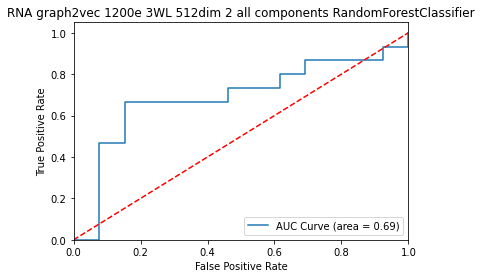

Model visualization, most relevant features:


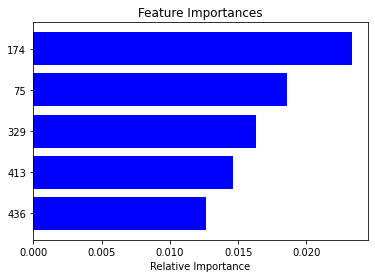

Using 153 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


Interpretability analysis using SHAP values:


100%|██████████| 28/28 [03:47<00:00,  8.13s/it]


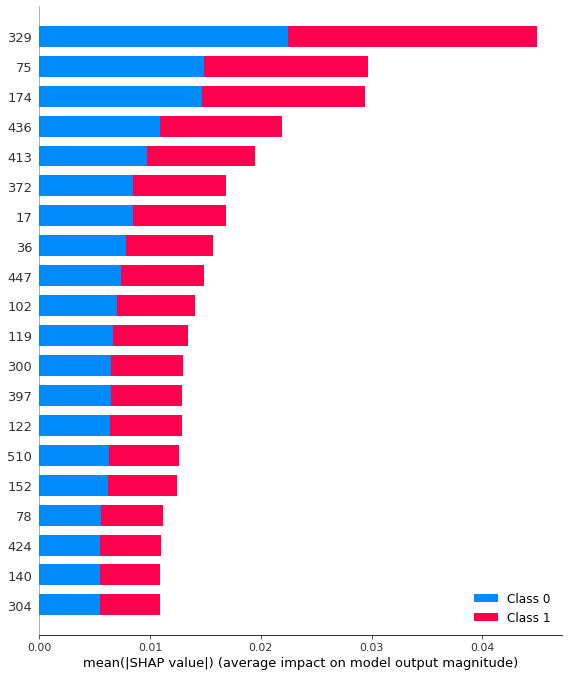

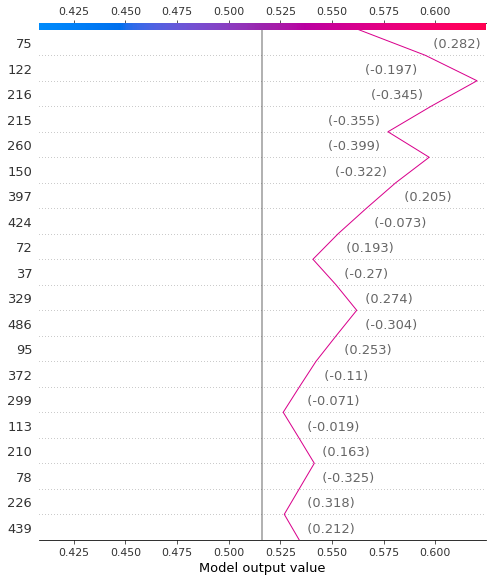

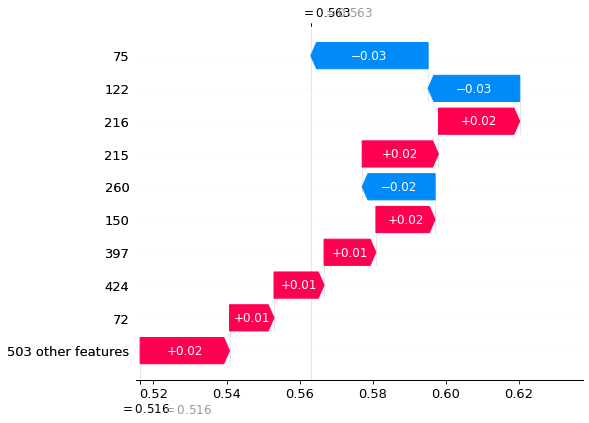

In [41]:
if __name__ == "__main__":
    for name in ['RandomForestClassifier']: #'MLPClassifier', 'RandomForestClassifier', 'SVC', 'LogisticRegression']:
        final_test = list(); final_train = list(); final_train_std = list(); final_val = list(); final_val_std = list()

        name = 'RandomForestClassifier'
        dim = 512
        e = 1200
        wl = 3
        print(f'RNA_graph2vec_{e}e_{wl}WL_{dim}dim')

        results = upload_data(f'../../graph_embedding/Results_embedding/Nivolumab/biogrid/RNA_graph2vec_{e}e_{wl}WL_{dim}dim.csv', '../../graph_embedding/Data/RNA_Disgenet_matrix_2_Nivolumab.csv')
        x = results.drop(columns='PFS_label')
        y = results['PFS_label'].replace({'NR':0, 'R':1}).values


        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, stratify=y, random_state=42)

        scaler = StandardScaler() # el scaler solo estaba entrenado en train, pero ni siquiera estaba aplicado a los datos
        scaler.fit(x_train)
        x_train_sc = scaler.transform(x_train)
        x_test_sc  = scaler.transform(x_test)


        score_list = {"balanced_accuracy": "balanced_accuracy",
                    "f1_weighted": "f1_weighted",
                    "roc_auc": "roc_auc",
                    "precision_weighted": "precision_weighted",
                    "recall_weighted": "recall_weighted",
                    "matthews_corrcoef": make_scorer(matthews_corrcoef)}

        test_ldf, train_ldf, train_ldf_std, val_ldf, val_ldf_std, model = cv_score(name, x_train, x_test, y_train, y_test, e, wl, dim, score_list)
        
        print('Model visualization, most relevant features:')
        model_visualization(x, model)
        print('Interpretability analysis using SHAP values:')
        perform_shap_values(model, x_train, x_test)


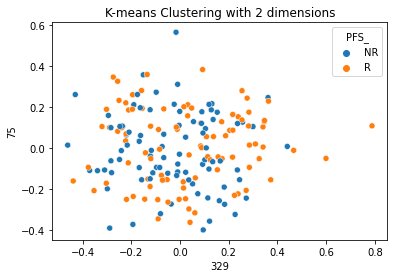

In [6]:
import seaborn as sns
from sklearn.decomposition import PCA
clusters = pd.read_csv('../../graph_embedding/Data/RNA_Disgenet_matrix_2_Nivolumab.csv')
clusters['PFS_'] = pd.cut(clusters['PFS'], bins=[0, 3.5, np.inf], labels=['NR', 'R'])

metadata = pd.read_csv(f'../../graph_embedding/Results_embedding/Nivolumab/biogrid/RNA_graph2vec_{1200}e_{3}WL_{512}dim.csv', index_col=0)
data = metadata[['329', '75']]
# data['PFS'] = clusters['PFS']
# print(data)
pca_num_components = 2

reduced_data = PCA(n_components=pca_num_components).fit_transform(data)
results = pd.DataFrame(reduced_data,columns=['329','75'])
# print(results)
sns.scatterplot(x="329", y="75", hue=clusters['PFS_'], data=results)
plt.title('K-means Clustering with 2 dimensions')
plt.show()
# metadata.columns

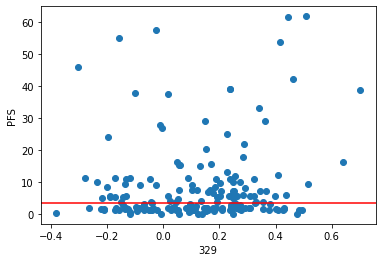

In [7]:
from matplotlib import pyplot

pyplot.scatter(metadata['329'], clusters['PFS'])
pyplot.xlabel('329')
pyplot.ylabel('PFS')
plt.axhline(y=3.5,color='r')

pyplot.show()

In [9]:
from scipy.stats import pearsonr

corr, _ = pearsonr(metadata['174'], clusters['PFS'])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: -0.052


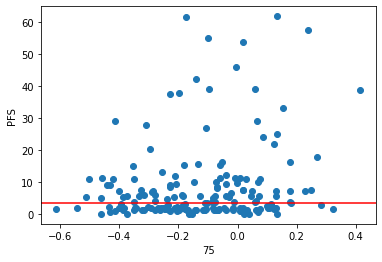

In [45]:
from matplotlib import pyplot

pyplot.scatter(metadata['75'], clusters['PFS'])
pyplot.xlabel('75')
pyplot.ylabel('PFS')
plt.axhline(y=3.5,color='r')
pyplot.show()

In [48]:
from scipy.stats import pearsonr

corr, _ = pearsonr(metadata['75'], clusters['PFS'])
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.206
